In [1]:
from pathlib import Path

from copy import deepcopy
import pickle
import seaborn as sns
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from applefy.detections.contrast import Contrast

from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma, LaplaceBootstrapTest
from applefy.utils.positions import center_subpixel

from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio

# 1. Load the data

In [2]:
hdf5_dataset = Path("/home/ipa/quanz/user_accounts/mbonse/2023_S4/30_data/HD22049_310_0100_C-0656_A_/HD22049_310_0100_C-0656_A_.hdf5")

In [3]:
science_data, angles, raw_psf_template_data = load_adi_data(
    hdf5_dataset=hdf5_dataset,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

science_data = science_data[:, 12:-12, 12:-12]

In [4]:
dit_psf_template = 0.0042560
dit_science = 0.08

psf_template = np.median(raw_psf_template_data, axis=0)

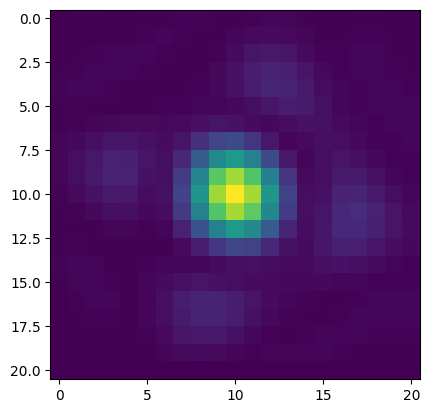

In [5]:
plt.imshow(psf_template)

In [6]:
psf_template = psf_template - np.min(psf_template)

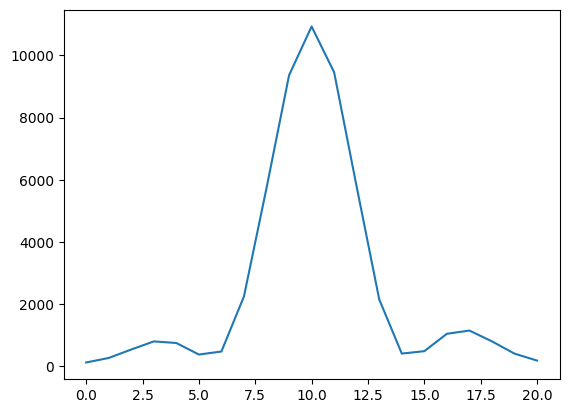

In [7]:
plt.plot(psf_template[10])

# 2. Fit the FWHM

In [8]:
from astropy.modeling.functional_models import Moffat2D
from astropy.modeling import fitting

In [9]:
# Fit the data using astropy.modeling
p_init = Moffat2D(amplitude=1e4, x_0=10, y_0=10)
fit_p = fitting.LevMarLSQFitter()

y, x = np.mgrid[:psf_template.shape[0],
                :psf_template.shape[1]]
p = fit_p(p_init, x, y, psf_template)

In [10]:
fwhm = np.round(p.fwhm, 1)
fwhm

3.6

Text(0.5, 1.0, 'Residual')

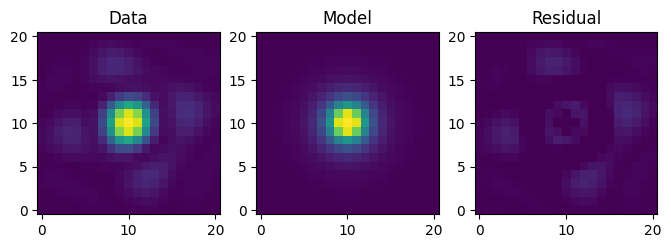

In [11]:
# Plot the data with the best-fit model
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(psf_template, 
           origin='lower', interpolation='nearest',
           vmin=0, vmax=1e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), 
           origin='lower', interpolation='nearest',
           vmin=0, vmax=1e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(psf_template - p(x, y),
           origin='lower', interpolation='nearest',
          vmin=0, vmax=1e4)
plt.title("Residual")

# 3.  Contrast Grid Setup

In [12]:
contrast_grid_dir = Path(
    "/home/ipa/quanz/user_accounts/mbonse/"
    "2023_S4/70_results/03_contrast_grid/pca_baseline/contrast_grid/") / hdf5_dataset.parent.name

contrast_grid_dir

PosixPath('/home/ipa/quanz/user_accounts/mbonse/2023_S4/70_results/03_contrast_grid/pca_baseline/contrast_grid/HD22049_310_0100_C-0656_A_')

In [13]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2.,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    checkpoint_dir=contrast_grid_dir)

## 3.2 Design fake planet experiments

In [14]:
# fake planet brightness
flux_ratios_mag = np.linspace(7., 15, 17)
flux_ratios = mag2flux_ratio(flux_ratios_mag)

print("Brightness of fake planets in mag: " + str(flux_ratios_mag))
print("Planet-to-star flux ratio: " + str(flux_ratios))

Brightness of fake planets in mag: [ 7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15. ]
Planet-to-star flux ratio: [1.58489319e-03 1.00000000e-03 6.30957344e-04 3.98107171e-04
 2.51188643e-04 1.58489319e-04 1.00000000e-04 6.30957344e-05
 3.98107171e-05 2.51188643e-05 1.58489319e-05 1.00000000e-05
 6.30957344e-06 3.98107171e-06 2.51188643e-06 1.58489319e-06
 1.00000000e-06]


In [15]:
center = center_subpixel(science_data[0])
inner_region = np.arange(fwhm/2, fwhm*5.5, fwhm / 2)[1:]
outer_region = np.arange(fwhm*5, center[0], fwhm)[1:]

separations = np.concatenate([inner_region, outer_region])
separations

array([ 3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. , 21.6, 25.2,
       28.8, 32.4, 36. , 39.6, 43.2, 46.8, 50.4, 54. , 57.6])

In [16]:
num_fake_planets = 3

contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


# 4. Run fake planet experiments

In [17]:
from applefy.wrappers.pynpoint import MultiComponentPCAPynPoint

In [18]:
components = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 
              25, 30, 35, 40, 45, 50, 60, 70, 80,
              90, 100, 120, 140, 160, 180, 200, 250, 300, 350, 400, 450, 500]

In [19]:
algorithm_function = MultiComponentPCAPynPoint(
    num_pcas=components,
    scratch_dir=Path("/scratch/user/mbonse/NACO_Archive") / hdf5_dataset.parent.name,
    num_cpus_pynpoint=1)

In [ ]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=algorithm_function,
    num_parallel=16)

Running fake planet experiments...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 880/1021 [01:17<00:32,  4.40it/s]

# 5. Compute the contrast grid

In [ ]:
# Use spaced pixel values
photometry_mode_planet = AperturePhotometryMode(
    "AS", # or "P" "FS"
    psf_fwhm_radius=fwhm/2.,
    search_area=0.5)
photometry_mode_noise = AperturePhotometryMode(
    "AS",
    psf_fwhm_radius=fwhm/2.)

In [ ]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [ ]:
statistical_test = TTest()

In [ ]:
contrast_curves_grid, contrast_grids = contrast_instance.compute_contrast_grids(
    statistical_test=statistical_test,
    num_cores=16,
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    num_rot_iter=20,
    safety_margin=2.5,
    pixel_scale=0.02718)

In [36]:
contrast_curves_grid

,,PCA (002 components),PCA (004 components),PCA (006 components),PCA (008 components),PCA (010 components),PCA (012 components),PCA (014 components),PCA (016 components),PCA (018 components),PCA (020 components),...,PCA (140 components),PCA (160 components),PCA (180 components),PCA (200 components),PCA (250 components),PCA (300 components),PCA (350 components),PCA (400 components),PCA (450 components),PCA (500 components)
separation [$FWHM$],separation [arcsec],,,,,,,,,,,,,,,,,,,,,
1.0,0.097848,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1.5,0.146772,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2.0,0.195696,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2.5,0.244620,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3.0,0.293544,inf,inf,inf,inf,inf,inf,0.001186,0.001237,0.001125,0.001064,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3.5,0.342468,0.001584,0.001246,0.001214,0.001065,0.000982,0.000930,0.000860,0.000816,0.000655,0.000595,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4.0,0.391392,0.000857,0.000676,0.000671,0.000645,0.000609,0.000613,0.000623,0.000575,0.000568,0.000535,...,0.000203,0.000172,0.000202,0.000293,inf,inf,inf,inf,inf,inf
4.5,0.440316,0.000569,0.000478,0.000453,0.000466,0.000454,0.000452,0.000449,0.000426,0.000411,0.000402,...,0.000112,0.000077,0.000086,0.000131,0.000234,0.000345,0.000510,inf,inf,inf
5.0,0.489240,0.000446,0.000354,0.000351,0.000337,0.000332,0.000327,0.000332,0.000319,0.000307,0.000306,...,0.000099,0.000099,0.000088,0.000080,0.000091,0.000095,0.000120,0.000205,inf,inf


# 6. Plot the Contrast Grid

In [37]:
import xarray as xr
import pandas as pd
from tqdm.auto import tqdm

In [38]:
contrast_grids_combined = xr.concat(
    [xr.DataArray(i) for i in contrast_grids.values()],
    pd.Index(
        [int(i[5:8]) for i in contrast_grids.keys()], 
        name='pca_components'))

In [39]:
best_contrast_grid = contrast_grids_combined.min(dim="pca_components").to_pandas()
best_pca_grid = contrast_grids_combined.idxmin(dim="pca_components").to_pandas()

In [40]:
# convert FPF to Gaussian Sigma
best_contrast_grid = best_contrast_grid.applymap(fpf_2_gaussian_sigma)

# convert flux_ratio to mag
best_contrast_grid.index = np.round(flux_ratio2mag(best_contrast_grid.index), 1)
best_pca_grid.index = np.round(flux_ratio2mag(best_pca_grid.index), 1)

best_contrast_grid.columns = np.round(best_contrast_grid.columns, 1)
best_pca_grid.columns = np.round(best_pca_grid.columns, 1)

In [41]:
def plot_contrast_grid(
    contrast_grid_axis,
    colorbar_axis,
    contrast_grid):

    c_bar_kargs = dict(
        orientation = "vertical",
        label = r"Confidence [$\sigma_{\mathcal{N}}$]")

    heat = sns.heatmap(
        contrast_grid,
        vmax=2, vmin=7,
        annot=True,
        cmap="YlGnBu",
        ax=contrast_grid_axis,
        cbar_ax=colorbar_axis,
        cbar_kws=c_bar_kargs)

    ylabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)
    
    xlabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_xticklabels()]
    _=heat.set_xticklabels(xlabels)

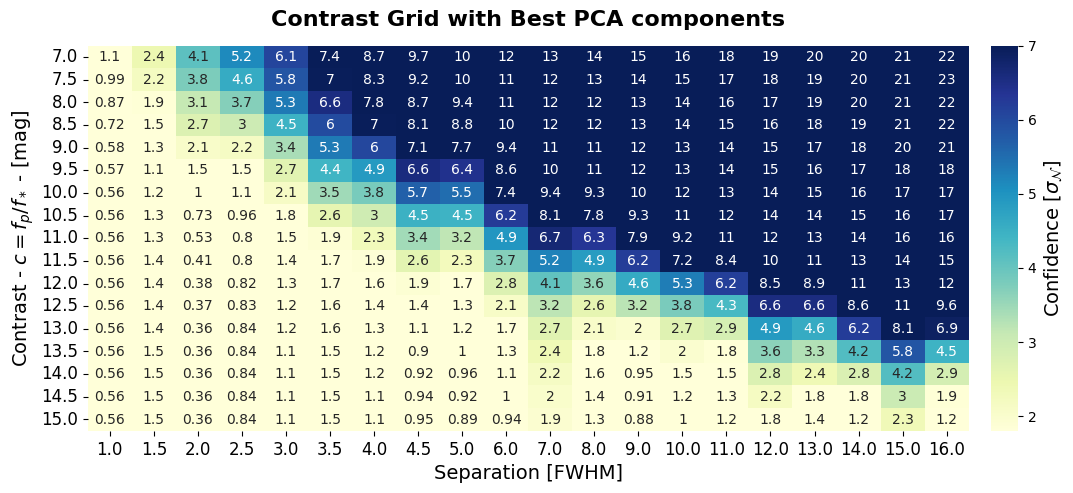

In [42]:
fig = plt.figure(figsize=(12, 5))

gs0 = fig.add_gridspec(1, 1)
gs0.update(wspace=0.0, hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec = gs0[0],
    wspace=0.05, width_ratios=[1, 0.03])

# All axis we need
contrast_ax = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs1[1])

# Plot the contrast grid
plot_contrast_grid(
    contrast_grid_axis=contrast_ax,
    colorbar_axis=colorbar_ax,
    contrast_grid=best_contrast_grid)

colorbar_ax.yaxis.label.set_size(14)

contrast_ax.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
contrast_ax.set_xlabel(
    r"Separation [FWHM]", size=14)
contrast_ax.set_title(
    "Contrast Grid with Best PCA components",
    fontsize=16,
    fontweight="bold",
    y=1.03)

contrast_ax.tick_params(
    axis='both',
    which='major',
    labelsize=12)

# Save the figure
fig.patch.set_facecolor('white')

# Get the limits of PCA

In [43]:
# Build the index table to find all config files
index_table = deepcopy(contrast_instance.contrast_results['PCA (006 components)'].idx_table)
index_table.columns = flux_ratio2mag(index_table.columns)
index_table.index = np.round(index_table.index, 1)

In [44]:
pca_limit_results = dict()


for tmp_separation in list(best_contrast_grid.columns):
    
    # 1. Find setups with less than 6 sigma confidence
    tmp_limit = best_contrast_grid[(
        best_contrast_grid<6.) & (best_contrast_grid>2.)] [tmp_separation].dropna()
    
    # 2. search for the top 4
    tmp_mags = list(tmp_limit.index)
    if len(tmp_mags) == 0:
        tmp_mags = [7.0, 7.5, 8.0, 8.5]
    
    # 3. Collect residuals
    tmp_mag_results = []
    
    for tmp_mag in tmp_mags:

        # 4.1 find the corresponding experiment idx
        tmp_idx = index_table.loc[np.round(tmp_separation*fwhm, 1)][tmp_mag]
        
        # 4.2 find the best number of pca components
        best_pca = int(best_pca_grid[tmp_separation][tmp_mags][tmp_mag])
        
        # 4.3 find the best residual
        best_name = 'PCA (' + str(best_pca).zfill(3) + ' components)'
        best_residuals = np.array(
            [i[0] for i in contrast_instance.contrast_results[best_name].planet_dict[tmp_idx]])
        
        # 4.4 find all residuals
        residuals = dict()
        for tmp_pca in components:
            tmp_name = 'PCA (' + str(tmp_pca).zfill(3) + ' components)'
            tmp_residuals =  np.array(
            [i[0] for i in contrast_instance.contrast_results[tmp_name].planet_dict[tmp_idx]])
            residuals[tmp_pca] = tmp_residuals
        
        tmp_mag_results.append((tmp_mag, tmp_idx, best_pca, best_residuals, residuals))

    pca_limit_results[np.round(tmp_separation, 1)] = tmp_mag_results

In [45]:
results_file = "/home/ipa/quanz/user_accounts/mbonse/2023_S4/70_results/03_contrast_grid/pca_baseline/limits/HD22049_310_0100_C-0656_A_/pca_limit_results.pkl"

In [71]:
with open(results_file, 'rb') as handle:
    pca_limit_results = pickle.load(handle)

In [64]:
number = 1  # higher number = fainter planet
sep = 5.0
pca_sel = 100#components[7]
planet_idx = 1

mag, idx, pca, best_residual, all_residuals = pca_limit_results[sep][number]
selected_residual = all_residuals[pca_sel]
confidence = best_contrast_grid[sep][mag]

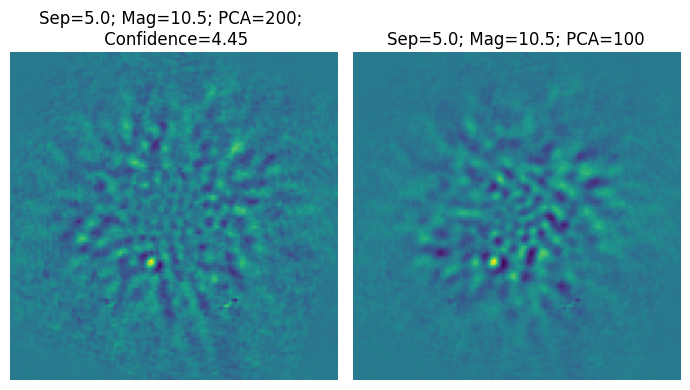

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (7, 4))

ax1.imshow(best_residual[planet_idx])
ax1.set_title("Sep=" + str(sep) + "; Mag=" + str(mag) + "; PCA=" + str(pca) + 
            "; \n Confidence=" + str(np.round(confidence, 2)))
ax1.axis("off")

ax2.imshow(selected_residual[planet_idx])
ax2.set_title("Sep=" + str(sep) + "; Mag=" + str(mag) + "; PCA=" + str(pca_sel))
_=ax2.axis("off")

plt.tight_layout()

In [66]:
with open(results_file, 'wb') as handle:
    pickle.dump(pca_limit_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 7. Plot the contrast curves

In [67]:
# compute the overall best contrast curve
overall_best = np.min(contrast_curves_grid.values, axis=1)

In [68]:
# Find one color for each number of PCA components used.
colors = sns.color_palette(
    "rocket_r",
    n_colors=len(contrast_curves_grid.columns))
colors

[(0.97628674, 0.87986189, 0.8057883),
 (0.97169389, 0.83320847, 0.73716071),
 (0.96810471, 0.78634563, 0.66773889),
 (0.96592829, 0.73844258, 0.60053991),
 (0.96492035, 0.69534192, 0.5451917),
 (0.96388426, 0.64484214, 0.4861196),
 (0.96228344, 0.59304598, 0.43145271),
 (0.95964538, 0.53983991, 0.38092784),
 (0.95626788, 0.49187351, 0.33985601),
 (0.95085121, 0.43500005, 0.29722817),
 (0.94291042, 0.37549479, 0.26369821),
 (0.93078135, 0.31373977, 0.24468803),
 (0.9144225, 0.26028902, 0.24369359),
 (0.88731387, 0.20469941, 0.25769539),
 (0.85281737, 0.15657772, 0.27909826),
 (0.81291606, 0.11645784, 0.30213802),
 (0.77344838, 0.09405684, 0.32136808),
 (0.72398193, 0.08688725, 0.33943958),
 (0.67159578, 0.09306598, 0.35159077),
 (0.61792306, 0.10325288, 0.35760108),
 (0.57077365, 0.11135597, 0.35827146),
 (0.51728314, 0.1179558, 0.35453252),
 (0.46461238, 0.12123063, 0.34667231),
 (0.41282936, 0.12164769, 0.33467689),
 (0.36827206, 0.11993653, 0.32076656),
 (0.31826327, 0.1157429, 0.30100076),
 (0.26930915, 0.1091727, 0.2772502),
 (0.22150014, 0.10013944, 0.2497868),
 (0.18065495, 0.09009031, 0.22303512),
 (0.13501631, 0.07585609, 0.19044109),
 (0.09011319, 0.05808059, 0.15797687),
 (0.04447016, 0.03648425, 0.12631831)]

In [69]:
separations_arcsec = contrast_curves_grid.reset_index(level=0).index
separations_FWHM = contrast_curves_grid.reset_index(level=1).index

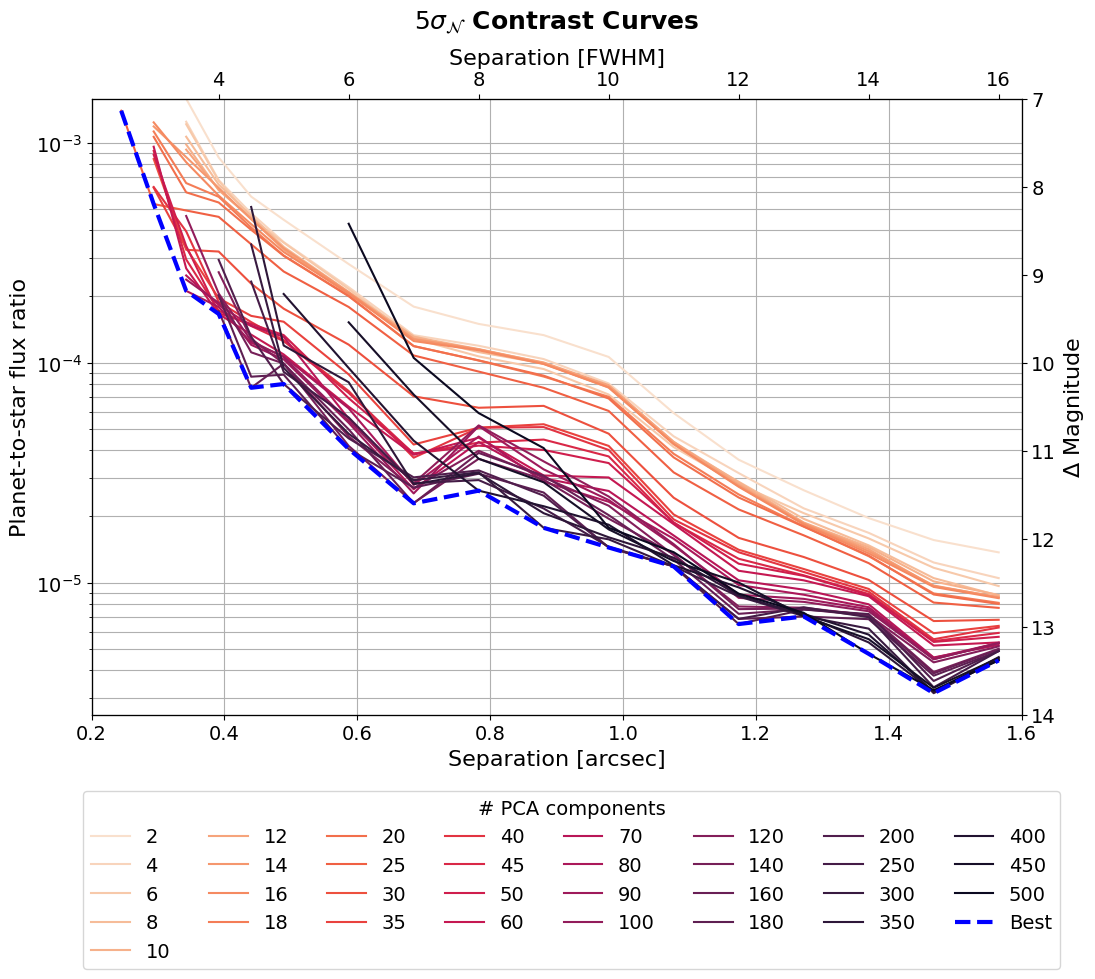

In [70]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(12, 8))
gs0 = fig.add_gridspec(1, 1)
axis_contrast_curvse = fig.add_subplot(gs0[0, 0])


# ---------------------- Create the Plot --------------------
i = 0 # color picker

for tmp_model in contrast_curves_grid.columns:

    num_components = int(tmp_model[5:9])
    tmp_flux_ratios = contrast_curves_grid.reset_index(
        level=0)[tmp_model].values

    axis_contrast_curvse.plot(separations_arcsec,
                              tmp_flux_ratios,
                              color = colors[i],
                              label=num_components)
    i+=1

axis_contrast_curvse.set_yscale("log")
# ------------ Plot the overall best -------------------------
axis_contrast_curvse.plot(
    separations_arcsec,
    overall_best,
    color = "blue",
    lw=3,
    ls="--",
    label="Best")

# ------------- Double axis and limits -----------------------
lim_mag_y = (14, 7)
lim_arcsec_x = (0.2, 1.6)
sep_lambda_arcse = interpolate.interp1d(
    separations_arcsec,
    separations_FWHM,
    fill_value='extrapolate')

axis_contrast_curvse_mag = axis_contrast_curvse.twinx()
axis_contrast_curvse_mag.plot(
    separations_arcsec,
    flux_ratio2mag(tmp_flux_ratios),
    alpha=0.)
axis_contrast_curvse_mag.invert_yaxis()

axis_contrast_curvse_lambda = axis_contrast_curvse.twiny()
axis_contrast_curvse_lambda.plot(
    separations_FWHM,
    tmp_flux_ratios,
    alpha=0.)

axis_contrast_curvse.grid(which='both')
axis_contrast_curvse_mag.set_ylim(*lim_mag_y)
axis_contrast_curvse.set_ylim(
    mag2flux_ratio(lim_mag_y[0]),
    mag2flux_ratio(lim_mag_y[1]))

axis_contrast_curvse.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_mag.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_lambda.set_xlim(
    *sep_lambda_arcse(lim_arcsec_x))

# ----------- Labels and fontsizes --------------------------

axis_contrast_curvse.set_xlabel(
    r"Separation [arcsec]", size=16)
axis_contrast_curvse_lambda.set_xlabel(
    r"Separation [FWHM]", size=16)

axis_contrast_curvse.set_ylabel(
    r"Planet-to-star flux ratio", size=16)
axis_contrast_curvse_mag.set_ylabel(
    r"$\Delta$ Magnitude", size=16)

axis_contrast_curvse.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_lambda.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_mag.tick_params(
    axis='both', which='major', labelsize=14)

axis_contrast_curvse_mag.set_title(
    r"$5 \sigma_{\mathcal{N}}$ Contrast Curves",
    fontsize=18, fontweight="bold", y=1.1)

# --------------------------- Legend -----------------------
handles, labels = axis_contrast_curvse.\
    get_legend_handles_labels()

leg1 = fig.legend(handles, labels,
                  bbox_to_anchor=(0.11, -0.22),
                  fontsize=14,
                  title="# PCA components",
                  loc='lower left', ncol=8)

_=plt.setp(leg1.get_title(),fontsize=14)